##Disclaimer: This is not investment advice

##Momentum Preamble
Absolute momentum strategy build on popular financial markets research on momnetum in asset prices. Research by Cliff Assness, Kent Daniel, Moskowitz have published many works showing that over long periods assests tend to show display some momentum. Their works also have reasonable explanations as to why a strategy as simple as momnetum works. The most popular time periods are: 1 year lookback and 1 month hold. 

Typical implementations involve picking the top performers in a certain asset class over the last 252 days (1 year) and holding for 1 month. Gary Antonacci proposed slight alterations:

1)Picking between a stock index and a bond index based off the past 1 year performance and holdng for the following month. 
2)Using the stocks absolute performance i.e returns in the past 1 year vs returns in the 1-year a month ago as the basis for deciding what to hold for the next 1 month i.e hold stock index if stockindex has outperformed itself, else hold bond index.

I adapt this further by reducing the amount traded each day to 1/21 of the portfolio. This is to account for starting point error i.e. the day of the month for rebalancing. My adaptation thus, averages the performace for each starting point in order to attain a less biased result. It also reduces transactions costs and whipsaws as only a small portion of the portfolio is traded daily. It has the added benefit of being allowed to hold amounts of the stock index and the bond index at some points in time. This gives it the benefit of diversification that a full portfolio turnover will not permit. The diversification benefit from stock index and bond index is significant (due to their strong ~20% to 50% anti-correlation.


##Absolute reversion
Similar to research on momnetum, financial researchers ..... have also found that the same way momnetum tends to work well with long lookbacks, reversion tends to work well with shorter ones. I have implemented an absolute reversion strategy similar to absolute momentum. SPecifically: 
1)It compares a stock index's last 3-month performance to its 3-month perfomance a month ago before the previous month. It holds the bond index if the stock index has outperformed its previous 3-month performance, otherwise it holds the stock index. My implementation also account for starting point discrepancies by trading only 1/5 of the portfolio (for each day of the week the portfolio can be rebablanced)

I have not accounted for transactions cost in this notebook

In [6]:
#install modules
!pip install fix-yahoo-finance==0.1.30
!pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#import modules
import numpy as np
from numpy import *
from numpy.linalg import multi_dot
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

import scipy.optimize as sco

import yfinance as yf

rcParams['figure.figsize'] = 16, 8

In [8]:
#define a function to calculate drawdowns and drawdown duration
def drd(cum_ret):
    hwm = []
    time_count = 0
    dur = []
    dd= []
    lowm = []
    for i in range(len(cum_ret)):
        if i == 0:
            hwm.append(cum_ret[i])
        else:
            if cum_ret[i]> hwm[-1]:
                hwm.append(cum_ret[i])
                dur.append(time_count)
                time_count = 0
                dd.append(0)
            else:
                dd.append((hwm[-1]- cum_ret[i])/hwm[-1])
                time_count = time_count + 1
        
    dd = pd.Series(dd).dropna()
    dur = pd.Series(dur).dropna()
    return dd, dur
    
#define function to print a sumary of asset performance
def print_summary(retss):
  period = 252
  print('alt_sharpe:',(retss.mean()/retss[retss<0].mean())*np.sqrt(period))
  print('sharpe:',(retss.mean()/retss.std())*np.sqrt(period))
  print('kelly:',(retss.mean()/retss.std()**2))
  print('stdev:',retss.std()*np.sqrt(period))#
  print('up_dev:',retss[retss > 0].mean())
  print('down_dev:',retss[retss < 0].mean())
  print('return:',retss.mean()*period)
  print('compounded return:',(np.prod(1+retss)**(1/len(retss)*period)-1))
  print('real_pl_proportion:',len(retss[retss>0])/len(retss))
  print('apparent_pl_proportion:',len(retss[retss>0])/len(retss[retss != 0]))
  print('activity_proportion:',len(retss[retss!=0])/len(retss))
  print('max drawdown:', drd(np.cumprod((1*retss+1)))[0].max())
  print('max underwater:', drd(np.cumprod((1*retss+1)))[1].max())
  


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(4, 4194)


Strategy
alt_sharpe: -1.529184882067805
sharpe: 0.9204969343654674
kelly: 7.540718528401827
stdev: 0.12207018878883372
up_dev: 0.004532954574412038
down_dev: -0.004628834961044504
return: 0.11236523455753528
compounded return: 0.11061326193898702
real_pl_proportion: 0.5524558893657606
apparent_pl_proportion: 0.5540411286465806
activity_proportion: 0.9971387696709585
max drawdown: 0.2541583932232909
max underwater: 276


Asset1
alt_sharpe: -0.896076733305336
sharpe: 0.6101034185594455
kelly: 3.4308584868403265
stdev: 0.17782820856634182
up_dev: 0.0068766758146246625
down_dev: -0.0076270859504704224
return: 0.10849359796262721
compounded return: 0.09710324155389016
real_pl_proportion: 0.553171196948021
apparent_pl_proportion: 0.555688622754491
activity_proportion: 0.9954697186456843
max drawdown: 0.5518946780379349
max underwater: 1223


As

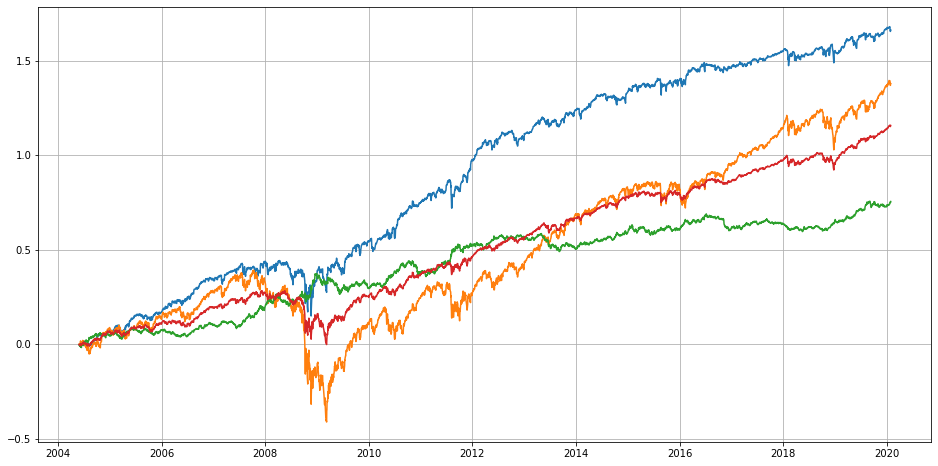

In [12]:
#define a function to run the reversal momnetum strategy
def absolute_momentum(stock, bond, hold = 5): # weekly approximation
    bond_ = bond
    stock_ = stock/1
    returnsZ = np.zeros(len(stock))
    lb = 1
    lb2 = 65
    lb3 = 5
    returnsZ[:lb+lb2] = .5*(stock_ + bond_)[:lb+lb2]
    retxZ = []
    hold = hold

    for j in range(1,hold):
      for i in range(lb+j, len(stock)-5,hold):
        if np.prod(1+stock[i-lb2:i-1]) - np.prod(1+stock[i-(lb2+lb3):i-lb3]) < 0* stock.std():
          returnsZ[i:i+hold] =  1.*stock_[i:i+hold]
        elif np.prod(1+stock[i-lb2:i-1]) - np.prod(1+stock[i-(lb2+lb3):i-lb3]) > -0* stock.std():
          returnsZ[i:i+hold] =  1.*bond_[i:i+hold] 

      retxZ.append(list(returnsZ))
    print(np.shape(retxZ))
    
    history = pd.Series(np.array(retxZ).mean(axis = 0))
    history.index = stock.index    

    return history


start= '2003-6-1'
end = '2020-1-30'
ohlc_selection = 'Adj Close'
asset = 1* yf.download('spy', start=start, end=end)[ohlc_selection].pct_change()[1:].fillna(0.000)
asset2 = 1* yf.download('ief', start=start, end=end)[ohlc_selection].pct_change()[1:].fillna(0.000)
combo = (asset + asset2)/2
strat = absolute_momentum(asset,asset2)

try:
  print('\n\nStrategy')
  print_summary(strat)
  print('\n\nAsset1')
  print_summary(asset)
  print('\n\nAsset2')
  print_summary(asset2)
  print('\n\n50:50')
  print_summary(combo)
  print('\n\nCorrelation')
  print('asset,       asset2,       combo,        strat')
  print(np.corrcoef([asset, asset2, combo, strat]))

  plt.figure()
  plt.plot(np.log(np.cumprod(1+strat[250:])))
  plt.plot(np.log(np.cumprod(1+(asset[250:]))))
  plt.plot(np.log(np.cumprod(1+asset2[250:])))
  plt.plot(np.log(np.cumprod(1+combo[250:])))
  plt.grid()

  print('\n\nSharpe (zero benchmark)')
  print('strategy sharpe:',np.sqrt(252)*strat.mean()/strat.std())
  print('asset sharpe:',np.sqrt(252)*(asset).mean()/(asset).std())
  print('asset2 sharpe:',np.sqrt(252)*(asset2).mean()/(asset2).std())
  print('50:50 sharpe:',np.sqrt(252)*(combo).mean()/(combo).std())
except:
  print('error somewhere')

strategy historical max drawdown:  25.598770547761607 %
asset historical max drawdown:  55.189455434590926 %
asset2 historical max drawdown:  18.872079579823474 %
50:50 historical max drawdown:  24.78859492028164 %


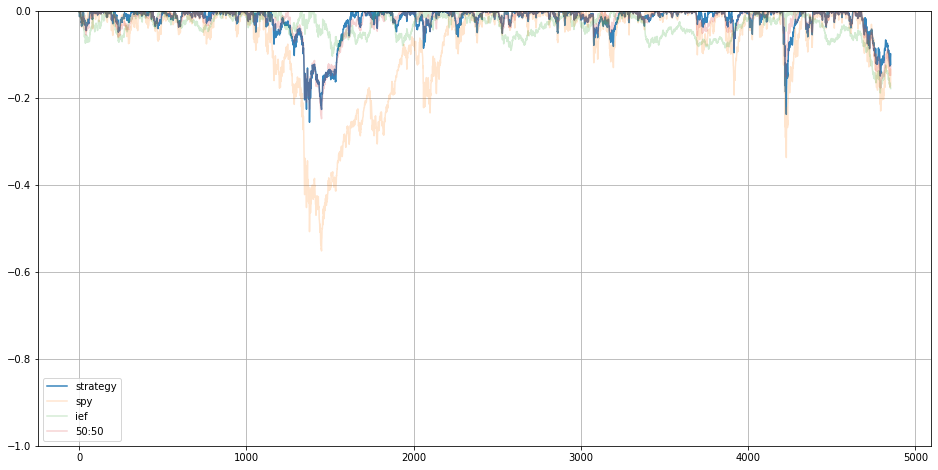

In [10]:
#calculate and visulaise drawdowns for the strategy and component assets

dd0, dur0 = drd(np.cumprod((1.*strat[:]+1)))
dd1, dur1 = drd(np.cumprod(1*asset+1))
dd2, dur2 = drd(np.cumprod(1*asset2 + 1))
dd3, dur3 = drd(np.cumprod(1*combo+1))

plt.plot(-1*dd0, alpha = 0.9)
plt.plot(-1*dd1, alpha = 0.2)
plt.plot(-1*dd2, alpha = 0.2)
plt.plot(-1*dd3, alpha = 0.2)

plt.legend(['strategy', 'asset1', 'asset2', '50:50', ], )

plt.grid()
plt.ylim([-1,0])
print('strategy historical max drawdown: ', dd0.max()*100, '%')
print('asset historical max drawdown: ', dd1.max()*100, '%')
print('asset2 historical max drawdown: ', dd2.max()*100, '%')
print('50:50 historical max drawdown: ', dd3.max()*100, '%')

plt.legend(["strategy", "spy", "ief", "50:50"])
